In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, date
import matplotlib.pyplot as plt
from numbers import Number

# credits and installation https://github.com/njchiang/tikhonov.git
from tikhonov.TikhonovRegression import Tikhonov

from sklearn.linear_model import LinearRegression
from scipy import stats

# Get pcm-dpc/COVID-19 data

In [2]:
def parse_date(date):
    return datetime.strptime(date[:10] + ' 23:59:00', '%Y-%m-%d %H:%M:%S')

In [3]:
italy_raw_data = pd.read_csv(
    'https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-andamento-nazionale/dpc-covid19-ita-andamento-nazionale.csv',
    parse_dates=['data'],
    date_parser=parse_date)

In [4]:
# https://github.com/CSSEGISandData/COVID-19/tree/master/csse_covid_19_data/csse_covid_19_time_series

# https://arxiv.org/pdf/2004.04529.pdf

# https://github.com/Keystone-Strategy/covid19-intervention-data/

# https://coviz.apps.allenai.org/

In [5]:
italy_raw_data

,data,stato,ricoverati_con_sintomi,terapia_intensiva,totale_ospedalizzati,isolamento_domiciliare,totale_positivi,variazione_totale_positivi,nuovi_positivi,dimessi_guariti,deceduti,casi_da_sospetto_diagnostico,casi_da_screening,totale_casi,tamponi,casi_testati,note
0,2020-02-24 23:59:00,ITA,101,26,127,94,221,0,221,1,7,NaN,NaN,229,4324,NaN,NaN
1,2020-02-25 23:59:00,ITA,114,35,150,162,311,90,93,1,10,NaN,NaN,322,8623,NaN,NaN
2,2020-02-26 23:59:00,ITA,128,36,164,221,385,74,78,3,12,NaN,NaN,400,9587,NaN,NaN
3,2020-02-27 23:59:00,ITA,248,56,304,284,588,203,250,45,17,NaN,NaN,650,12014,NaN,NaN
4,2020-02-28 23:59:00,ITA,345,64,409,412,821,233,238,46,21,NaN,NaN,888,15695,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
260,2020-11-10 23:59:00,ITA,28633,2971,31604,558506,590110,16776,35098,363023,42330,636202.0,359261.0,995463,17740196,10765561.0,NaN
261,2020-11-11 23:59:00,ITA,29444,3081,32525,580833,613358,23248,32961,372113,42953,657205.0,371219.0,1028424,17965836,10891971.0,NaN
262,2020-11-12 23:59:00,ITA,29873,3170,33043,602011,635054,21696,37978,387758,43589,674591.0,391810.0,1066401,18200508,11025449.0,NaN
263,2020-11-13 23:59:00,ITA,30914,3230,34144,629782,663926,28872,40902,399238,44139,697312.0,409991.0,1107303,18455416,11170324.0,NaN


In [6]:
italy_raw_data.columns

Index(['data', 'stato', 'ricoverati_con_sintomi', 'terapia_intensiva',
       'totale_ospedalizzati', 'isolamento_domiciliare', 'totale_positivi',
       'variazione_totale_positivi', 'nuovi_positivi', 'dimessi_guariti',
       'deceduti', 'casi_da_sospetto_diagnostico', 'casi_da_screening',
       'totale_casi', 'tamponi', 'casi_testati', 'note'],
      dtype='object')

In [7]:
TIMESTEPS = len(italy_raw_data.nuovi_positivi)

## Check data consistency

In [8]:
italy_raw_data.describe()

,ricoverati_con_sintomi,terapia_intensiva,totale_ospedalizzati,isolamento_domiciliare,totale_positivi,variazione_totale_positivi,nuovi_positivi,dimessi_guariti,deceduti,casi_da_sospetto_diagnostico,casi_da_screening,totale_casi,tamponi,casi_testati
count,265.000000,265.000000,265.000000,265.000000,265.000000,265.000000,265.000000,265.000000,265.000000,143.000000,143.000000,2.650000e+02,2.650000e+02,2.100000e+02
mean,8836.894340,965.558491,9802.456604,69219.475472,79021.928302,2597.033962,4319.596226,157849.332075,29172.909434,282141.545455,79892.503497,2.660442e+05,6.249206e+06,4.721341e+06
std,9563.276367,1190.630838,10720.033309,115708.771653,121858.615781,6734.677493,8386.412265,94257.071157,11741.360043,114175.506232,92654.142149,1.931499e+05,4.931156e+06,2.629807e+06
min,101.000000,26.000000,127.000000,94.000000,221.000000,-6939.000000,78.000000,1.000000,7.000000,221994.000000,15801.000000,2.290000e+02,4.324000e+03,9.353100e+05
25%,1090.000000,93.000000,1198.000000,13691.000000,15089.000000,-321.000000,329.000000,75945.000000,27967.000000,222999.000000,24615.500000,2.054630e+05,1.979217e+06,2.721802e+06
50%,3925.000000,319.000000,4283.000000,33708.000000,40532.000000,428.000000,1350.000000,192108.000000,34861.000000,231587.000000,43057.000000,2.416110e+05,5.638288e+06,4.105820e+06
75%,15174.000000,1536.000000,16620.000000,67950.000000,87961.000000,1941.000000,3526.000000,211272.000000,35577.000000,265728.500000,80903.500000,2.815830e+05,9.460203e+06,6.439821e+06
max,31398.000000,4068.000000,34704.000000,653731.000000,688435.000000,33418.000000,40902.000000,411434.000000,44683.000000,718482.000000,426070.000000,1.144552e+06,1.868311e+07,1.130544e+07


In [9]:
(italy_raw_data.totale_positivi 
 + italy_raw_data.dimessi_guariti 
 + italy_raw_data.deceduti 
 == italy_raw_data.totale_casi).all()

False

In [10]:
italy_raw_data.loc[
    italy_raw_data.totale_positivi 
    + italy_raw_data.dimessi_guariti 
    + italy_raw_data.deceduti 
    != italy_raw_data.totale_casi,
    ['data', 'totale_positivi', 'dimessi_guariti', 'deceduti', 'totale_casi']
]

,data,totale_positivi,dimessi_guariti,deceduti,totale_casi
254,2020-11-04 23:59:00,443235,307378,39747,790377


In [11]:
italy_raw_data.loc[
    italy_raw_data.ricoverati_con_sintomi
    + italy_raw_data.terapia_intensiva
    != italy_raw_data.totale_ospedalizzati,
    ['data', 'ricoverati_con_sintomi', 'terapia_intensiva', 'totale_ospedalizzati']    
]

,data,ricoverati_con_sintomi,terapia_intensiva,totale_ospedalizzati
1,2020-02-25 23:59:00,114,35,150


In [12]:
italy_raw_data.loc[
    italy_raw_data.totale_ospedalizzati 
    + italy_raw_data.isolamento_domiciliare 
    != italy_raw_data.totale_positivi,
    ['data', 'totale_ospedalizzati', 'isolamento_domiciliare', 'totale_positivi']    
]

,data,totale_ospedalizzati,isolamento_domiciliare,totale_positivi
1,2020-02-25 23:59:00,150,162,311


In [13]:
italy_raw_data.loc[
    italy_raw_data.ricoverati_con_sintomi
    + italy_raw_data.terapia_intensiva
    + italy_raw_data.isolamento_domiciliare
    != italy_raw_data.totale_positivi,
    ['data', 'ricoverati_con_sintomi', 'terapia_intensiva', 'isolamento_domiciliare', 
     'totale_positivi']    
]

,data,ricoverati_con_sintomi,terapia_intensiva,isolamento_domiciliare,totale_positivi


In [14]:
italy_raw_data.loc[
    italy_raw_data.ricoverati_con_sintomi
    + italy_raw_data.terapia_intensiva
    + italy_raw_data.isolamento_domiciliare
    + italy_raw_data.dimessi_guariti 
    + italy_raw_data.deceduti 
    != italy_raw_data.totale_casi,
    ['data', 'ricoverati_con_sintomi', 'terapia_intensiva', 'isolamento_domiciliare', 
     'dimessi_guariti', 'deceduti', 'totale_casi']    
]

,data,ricoverati_con_sintomi,terapia_intensiva,isolamento_domiciliare,dimessi_guariti,deceduti,totale_casi
254,2020-11-04 23:59:00,22116,2292,418827,307378,39747,790377


# Fix NaN data

`casi_da_sospetto_diagnostico` and `casi_da_screening` have been measured only after a certain date

In [15]:
FIRST_CASI_SOSP_DIAGNOSTICO = italy_raw_data.casi_da_sospetto_diagnostico.first_valid_index()
italy_raw_data.loc[FIRST_CASI_SOSP_DIAGNOSTICO,['data']]

data    2020-06-25 23:59:00
Name: 122, dtype: object

In [16]:
italy_raw_data.loc[italy_raw_data.casi_da_screening.first_valid_index(),['data']]

data    2020-06-25 23:59:00
Name: 122, dtype: object

In [17]:
italy_raw_data.casi_da_sospetto_diagnostico.fillna(0, inplace=True)
italy_raw_data.casi_da_screening.fillna(0, inplace=True)

# Compute new cases

In [18]:
italy_raw_data['nuovi_casi_da_sospetto_diagnostico'] = \
    (italy_raw_data.casi_da_sospetto_diagnostico -
     italy_raw_data.casi_da_sospetto_diagnostico.shift(1)).fillna(0)

In [19]:
italy_raw_data['nuovi_casi_da_screening'] = \
    (italy_raw_data.casi_da_screening -
     italy_raw_data.casi_da_screening.shift(1)).fillna(0)

# Smoothing data

## Function `smooth_data`

Data are smoothed by fitting a series to represent the derivative of the original signal and then integrating it back to the original signal, which results in a smoothed one.


Given $y$ the signal to be smoothed, we search for the differential signal $\omega$ such that:
$$y = X\cdot \omega$$
where $X$ is the matrix representing the integration operator:
$$X = \begin{bmatrix} 
1 & 0 & 0 & ... & 0 \\
1 & 1 & 0 & ... & 0 \\
1 & 1 & 1 & ... & 0 \\
... & ... & ... & ...  & ... \\
1 & 1 & ... & ... & 1 \\
\end{bmatrix}
$$

$\omega$ is obtained by minimizing the following cost function:
$$F(\omega) = \left\|y - X\cdot\omega\right\|^2 +\alpha^2 \left\|\Gamma\cdot\omega\right\|^2$$

Hence the derivative is fitted using a Ridge regresssion with a generalized Tikhonov regularization factor:
- $y$: the original signal
- $X$: we choose the the integration matrix, to force the fitted signal to be the derivative one
- $\Gamma$: the Tikhonov regularizaztion matrix, choosen as the second derivative operator
- $\alpha$: the regularization factor

The regularization factor penalizes the noise, forcing the derivative to be a smoothed signal.
Once the derivative is fitted, then the original signal is reconstructed by appliyng again the integral matrix to the differentiated signal. The bigger the alpha factor, the smoother the signal.

## Function `smooth_differentiate`
As a by product of this procedure, we can apply the fit to cumulative data to obtain the daily variations, eg to obtain the "nuovi_positivi" from the "totale_casi"

## Function `filter_matrices`
Integral and derivative matrices are just the matrices that applyed to a signal produce the integral or the derivative. They are built via `np.tril`, `np.ones` and `np.eye`.


In [20]:
def filter_matrices(timesteps):
    
    integral_matrix = np.tri(timesteps,timesteps,0)

    derivative_matrix = np.eye(timesteps,timesteps)-(np.tri(timesteps,timesteps,-1)-np.tri(timesteps,timesteps,-2))

    second_derivative_matrix = np.dot(derivative_matrix, derivative_matrix)
    
    return integral_matrix, second_derivative_matrix 


In [21]:
ALPHA = 100.

INTEGRAL_MATRIX, SECOND_DERIVATIVE_MATRIX = filter_matrices(TIMESTEPS)

GAMMA = SECOND_DERIVATIVE_MATRIX

In [22]:
def smooth_data(y, X, L, alpha):    
    tic = Tikhonov(alpha=alpha)
    tic.fit(y=y, X=X, L=L)
    print('TIC R2: {}'.format(tic.score(X=X, y=y)))
    
    return tic.predict(X)

def smooth_differentiate(y, X, L, alpha):
    tic = Tikhonov(alpha=alpha)
    tic.fit(y=y, X=X, L=L)
    print('TIC R2: {}'.format(tic.score(X=X, y=y)))
    
    return tic.coef_

In [23]:
italy_raw_data['tamponi_giornalieri'] = (italy_raw_data.tamponi - italy_raw_data.tamponi.shift(1)).fillna(0)
italy_raw_data['tamponi_giornalieri_smoothed'] = smooth_differentiate(italy_raw_data.tamponi, 
                                                                      X=INTEGRAL_MATRIX,
                                                                      L=GAMMA,
                                                                      alpha=ALPHA)

TIC R2: 0.9999906033995195


In [24]:
italy_raw_data['dimessi_guariti_giornalieri'] = (italy_raw_data.dimessi_guariti - italy_raw_data.dimessi_guariti.shift(1)).fillna(0)
italy_raw_data['dimessi_guariti_giornalieri_smoothed'] = smooth_differentiate(italy_raw_data.dimessi_guariti,
                                                                              X=INTEGRAL_MATRIX,
                                                                              L=GAMMA,
                                                                              alpha=ALPHA)

TIC R2: 0.999953362461714


In [25]:
italy_raw_data['deceduti_giornalieri'] = (italy_raw_data.deceduti - italy_raw_data.deceduti.shift(1)).fillna(0)
italy_raw_data['deceduti_giornalieri_smoothed'] = smooth_differentiate(italy_raw_data.deceduti,
                                                                       X=INTEGRAL_MATRIX,
                                                                       L=GAMMA,
                                                                       alpha=200.)

TIC R2: 0.9999911753961181


In [26]:
italy_raw_data['nuovi_positivi_smoothed'] = smooth_differentiate(italy_raw_data.totale_casi,
                                                                 X=INTEGRAL_MATRIX,
                                                                 L=GAMMA,
                                                                 alpha=ALPHA)

TIC R2: 0.9999643075170911


In [27]:
italy_raw_data['nuovi_casi_da_sospetto_diagnostico_smoothed'] = \
    smooth_differentiate(italy_raw_data.casi_da_sospetto_diagnostico,
                         X=INTEGRAL_MATRIX,
                         L=GAMMA,
                         alpha=ALPHA)

TIC R2: 0.9959158779039116


In [28]:
italy_raw_data['nuovi_casi_da_screening_smoothed'] = \
    smooth_differentiate(italy_raw_data.casi_da_screening,
                         X=INTEGRAL_MATRIX,
                         L=GAMMA,
                         alpha=ALPHA)

TIC R2: 0.9998558874230117


In [29]:
filter_columns = [
    'ricoverati_con_sintomi', 'terapia_intensiva',
    'isolamento_domiciliare', 'totale_positivi',
    'dimessi_guariti', 'deceduti', 'tamponi', 'totale_casi', 'casi_da_screening',
    'casi_da_sospetto_diagnostico'
]

for col in filter_columns:
    italy_raw_data[col+'_smoothed'] = smooth_data(y=italy_raw_data[col],
                                              X=INTEGRAL_MATRIX,
                                              L=GAMMA,
                                              alpha=ALPHA)

TIC R2: 0.9997572913115853
TIC R2: 0.9998534913460079
TIC R2: 0.9998681168764707
TIC R2: 0.9998825122653702
TIC R2: 0.999953362461714
TIC R2: 0.9999917945897653
TIC R2: 0.9999906033995195
TIC R2: 0.9999643075170911
TIC R2: 0.9998558874230117
TIC R2: 0.9959158779039116


# Compute $R_t$

Definitions and parameters are form Ref: https://it.m.wikipedia.org/wiki/Numero_di_riproduzione_di_base

$R_t$ si defined as:

$$\large{R_t = \frac{I_t}{\sum_{s=1}^t w_s I_{t-s}}}$$

Where:
- $I_t$ is `nuovi_positivi` at day t, or any first difference of a cumulative value
- $w_s=\Gamma(s; \alpha,\beta)$
- $\alpha = 1.87$
- $\beta = 0.28$

In [30]:
def gamma_df(x, alpha, beta):
    return stats.gamma.pdf(x, a=alpha, scale=1/beta)

In [31]:
def gamma_pf(x, alpha, beta):
    return stats.gamma.ppf(x, a=alpha, scale=1/beta)

In [32]:
def Rt(series, alpha, beta):
    steps = len(series)
    x = np.linspace(1,steps-1, steps)
    w = gamma_df(x, alpha, beta)
    
    infectious_charge = [np.nan] + [
        sum(series[t-1::-1]*w[:t]) 
        for t in range(1, steps)        
    ]
    
    return series / infectious_charge

## Compute $R_t$ on every first difference available

Computation is performed for the following fields:
- `nuovi_positivi`: first difference of `nuovi_casi`
- `nuovi_casi_da_sospetto_diagnostico`: first difference of `casi_da_sospetto_diagnostico`
- `nuovi_casi_da_screening`: first difference of `casi_da_screening`

Each computation is performed both on the raw values **and on the smoothed values**.

In [35]:
alpha = 1.87
beta = 0.28

rt_on_fields = [
    'nuovi_positivi',
    'nuovi_casi_da_sospetto_diagnostico',
    'nuovi_casi_da_screening'
]

for c in rt_on_fields + ['{}_smoothed'.format(c) for c in rt_on_fields]:
    italy_raw_data['{}_Rt'.format(c)] = Rt(italy_raw_data[c], alpha=alpha, beta=beta).fillna(0)

In [54]:
def plot_series(title, df, yfields, xfield='data', ylim=None, xlim=None):
    fig, ax1 = plt.subplots(figsize=(30,15))
    ax1.set_title(title, fontsize=30)
    ax1.set_xlabel('time (days)', fontsize=30)
    ax1.tick_params(axis='both', labelsize=30)
    if ylim:
        ax1.set_ylim(*ylim)
    if xlim:
        ax1.set_xlim(*xlim)

    for f in yfields:
        ax1.plot(
            df[xfield], 
            df[f], 
            label=f, 
            linestyle=':', marker='o'
        )

    _ = ax1.legend(fontsize=27, loc='upper left')    

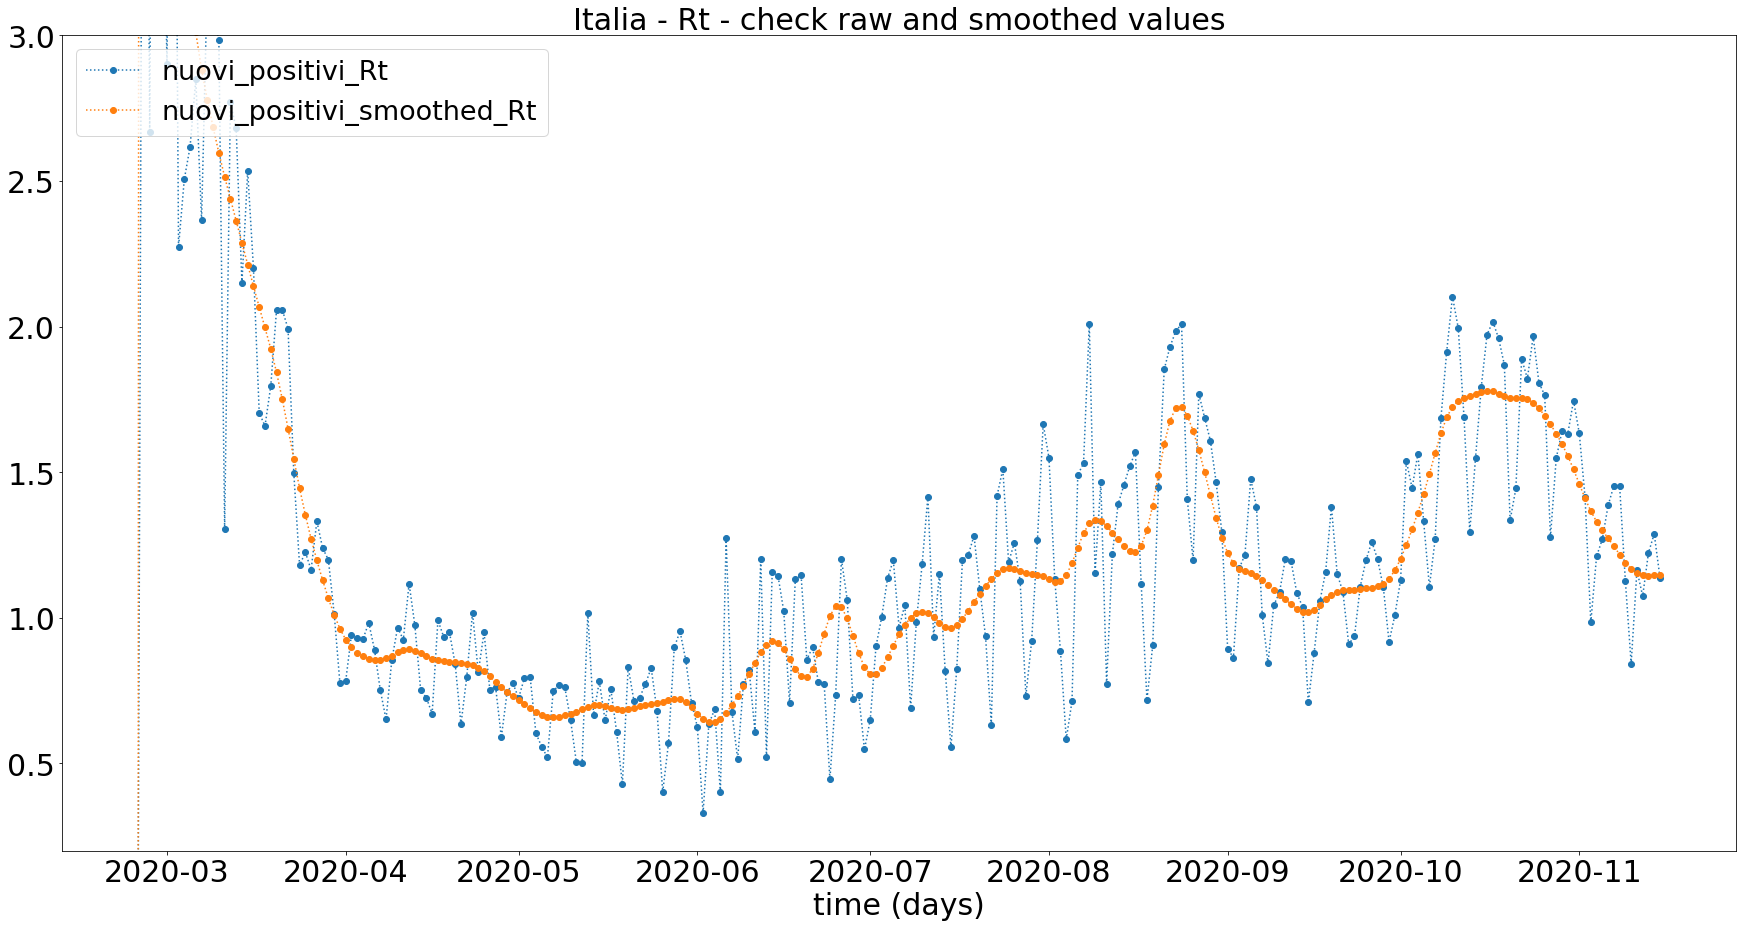

In [67]:
plot_series(
    'Italia - Rt - check raw and smoothed values',    
    italy_raw_data, 
    [
        'nuovi_positivi_Rt',
        'nuovi_positivi_smoothed_Rt'
    ],
    ylim=(0.2,3)
)

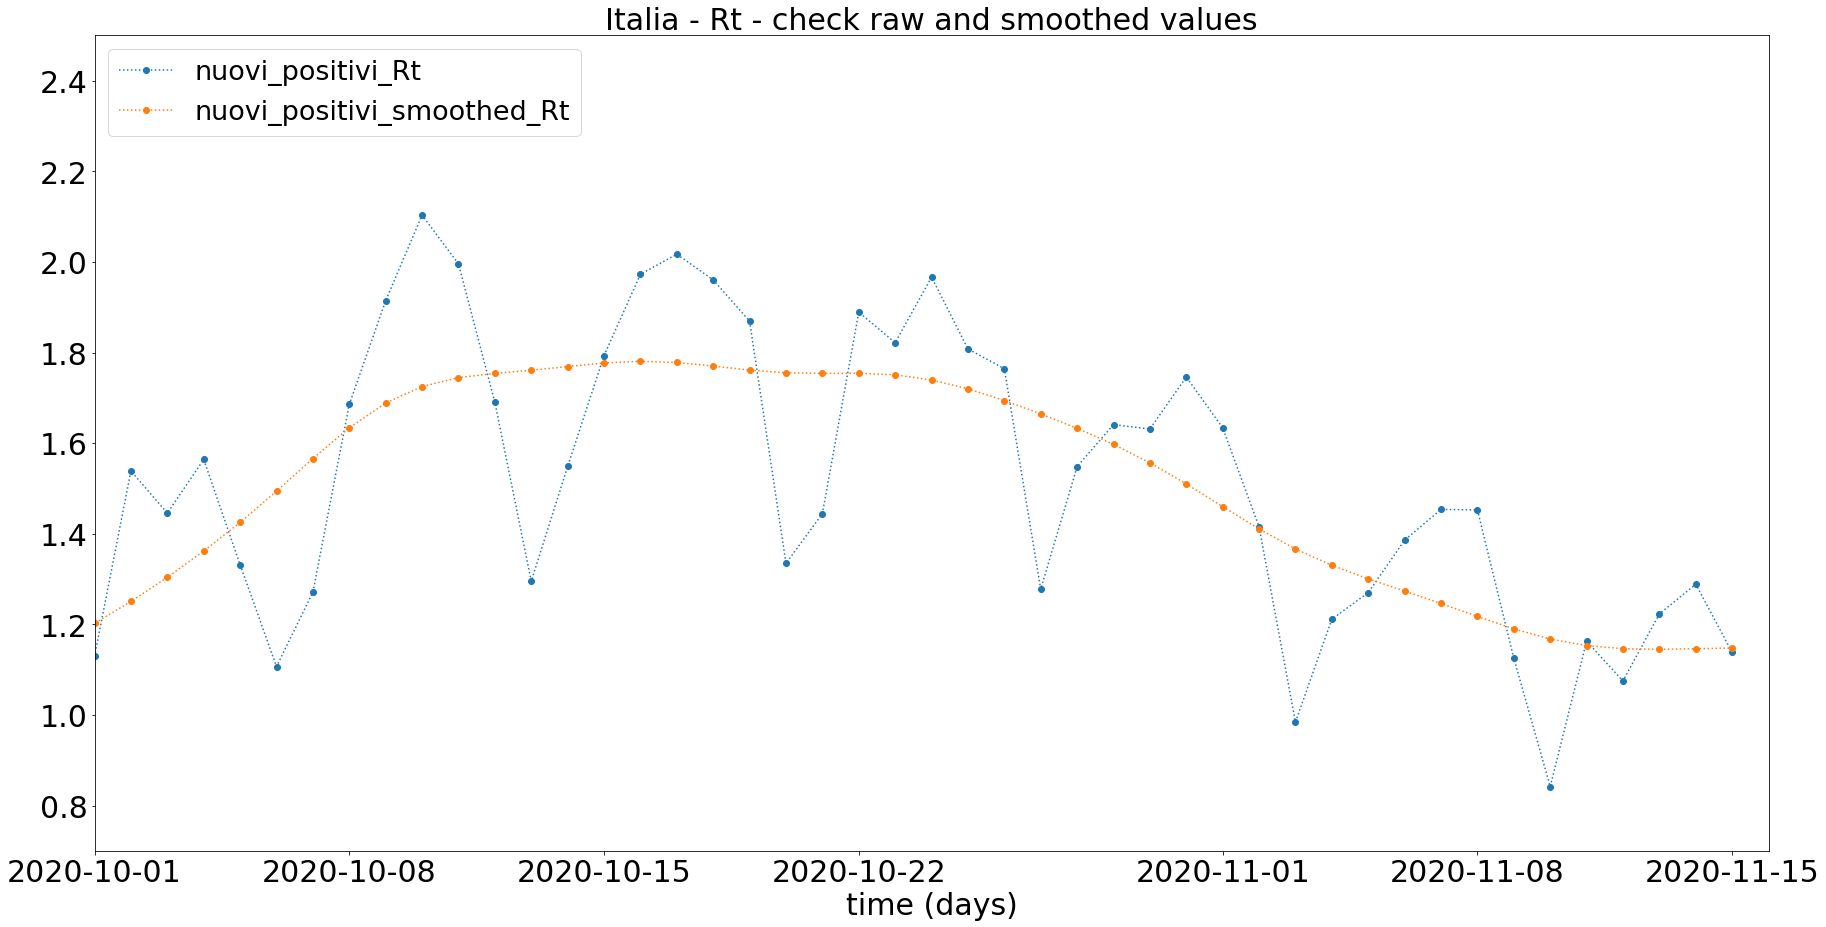

In [66]:
plot_series(
    'Italia - Rt - check raw and smoothed values',    
    italy_raw_data, 
    [
        'nuovi_positivi_Rt',
        'nuovi_positivi_smoothed_Rt'
    ],
    ylim=(0.7,2.5),
    xlim=(datetime(2020,10,1),datetime(2020,11,16))
)

## Compare $R_t$ values computed on the 3 first differences

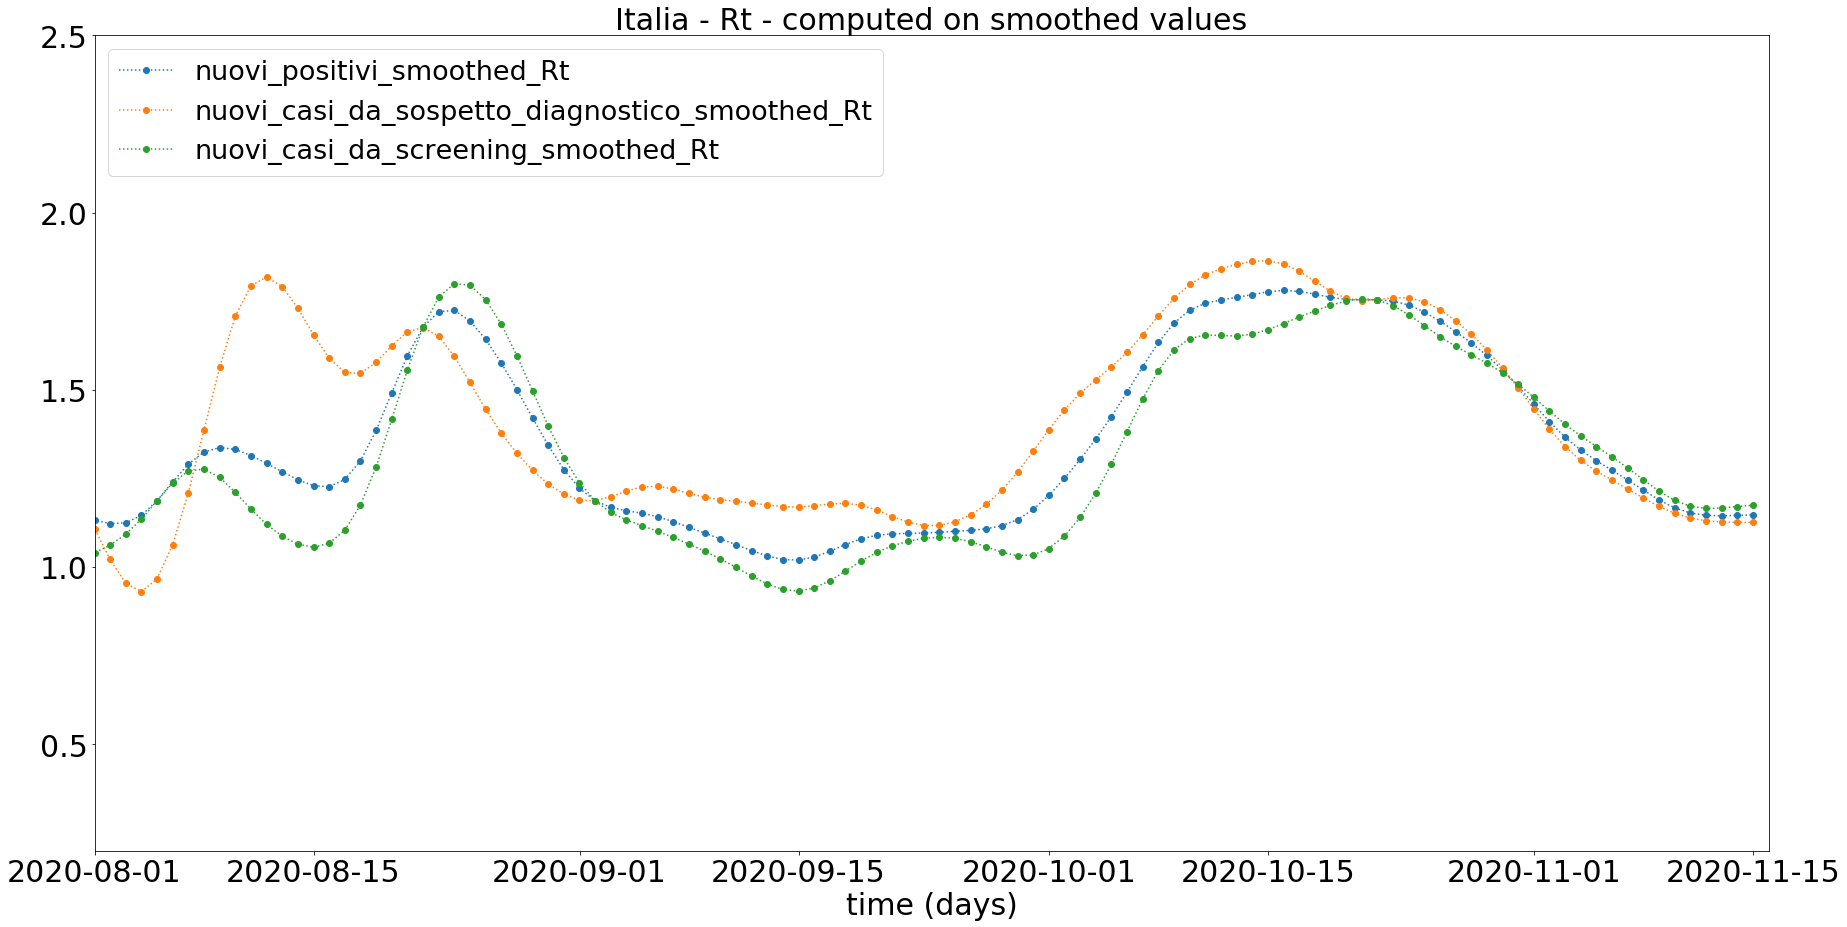

In [65]:
plot_series(
    'Italia - Rt - computed on smoothed values',    
    italy_raw_data, 
    [
        'nuovi_positivi_smoothed_Rt',
        'nuovi_casi_da_sospetto_diagnostico_smoothed_Rt',
        'nuovi_casi_da_screening_smoothed_Rt'
    ],
    ylim=(0.2,2.5),
    xlim=(datetime(2020,8,1),datetime(2020,11,16))
)

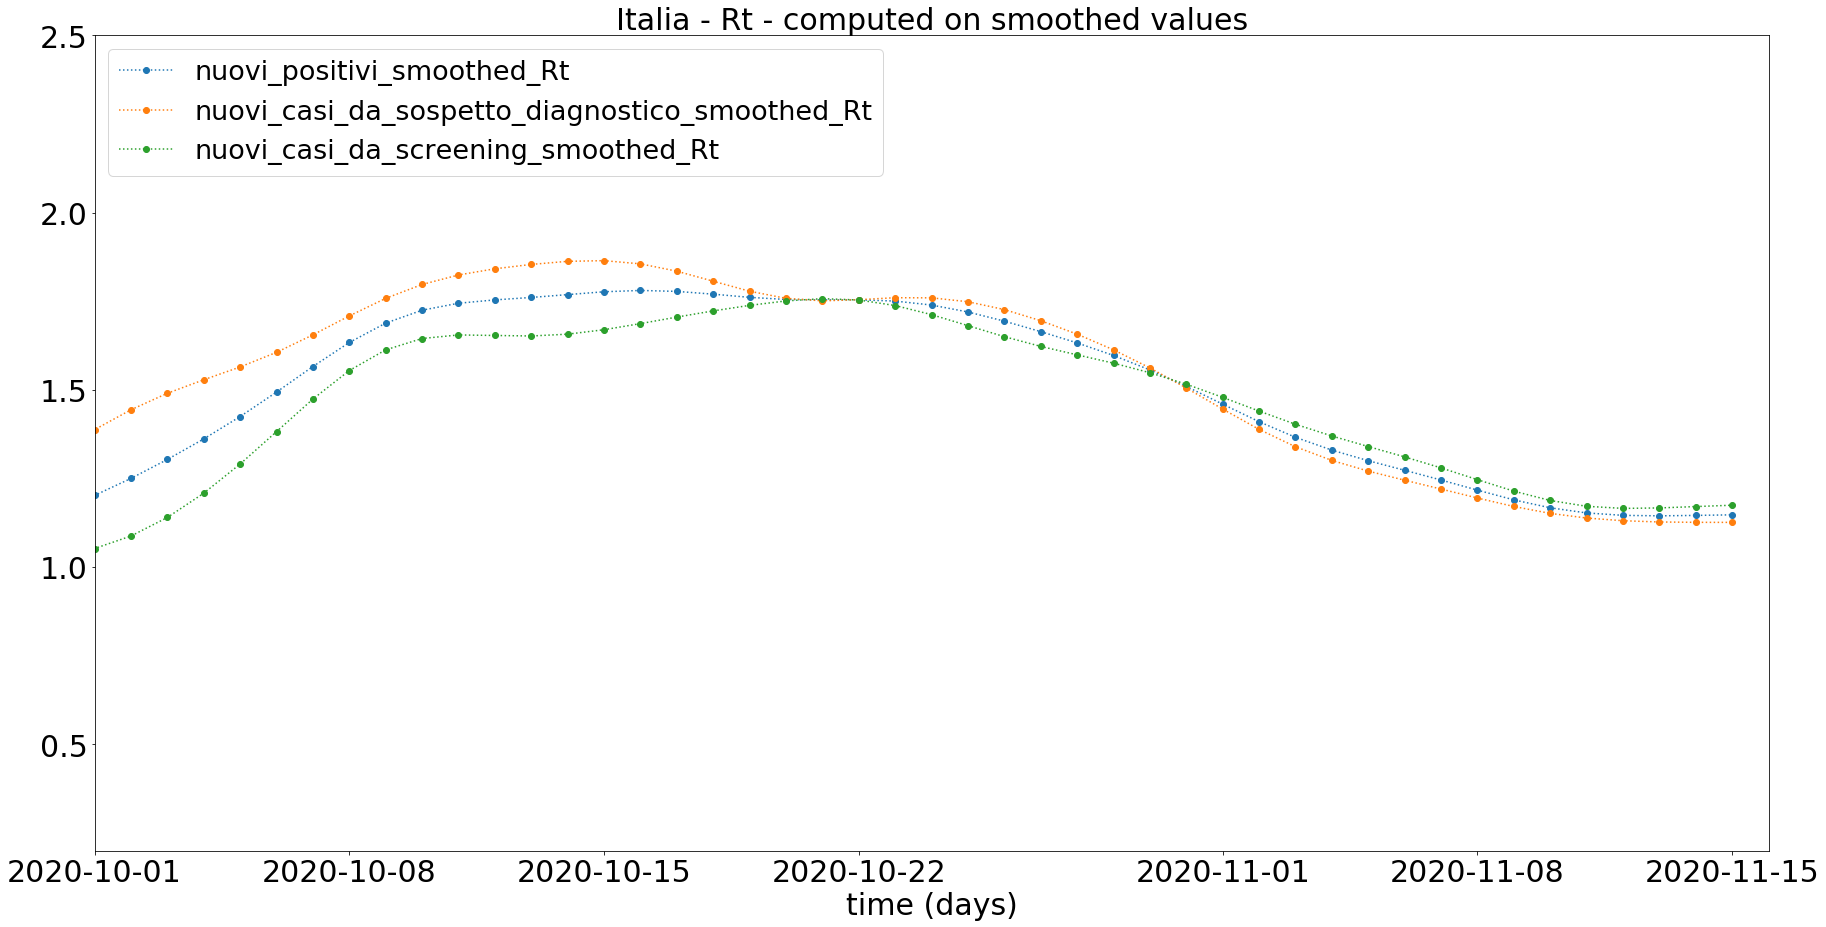

In [63]:
plot_series(
    'Italia - Rt - computed on smoothed values',    
    italy_raw_data, 
    [
        'nuovi_positivi_smoothed_Rt',
        'nuovi_casi_da_sospetto_diagnostico_smoothed_Rt',
        'nuovi_casi_da_screening_smoothed_Rt'
    ],
    ylim=(0.2,2.5),
    xlim=(datetime(2020,10,1),datetime(2020,11,16))
)

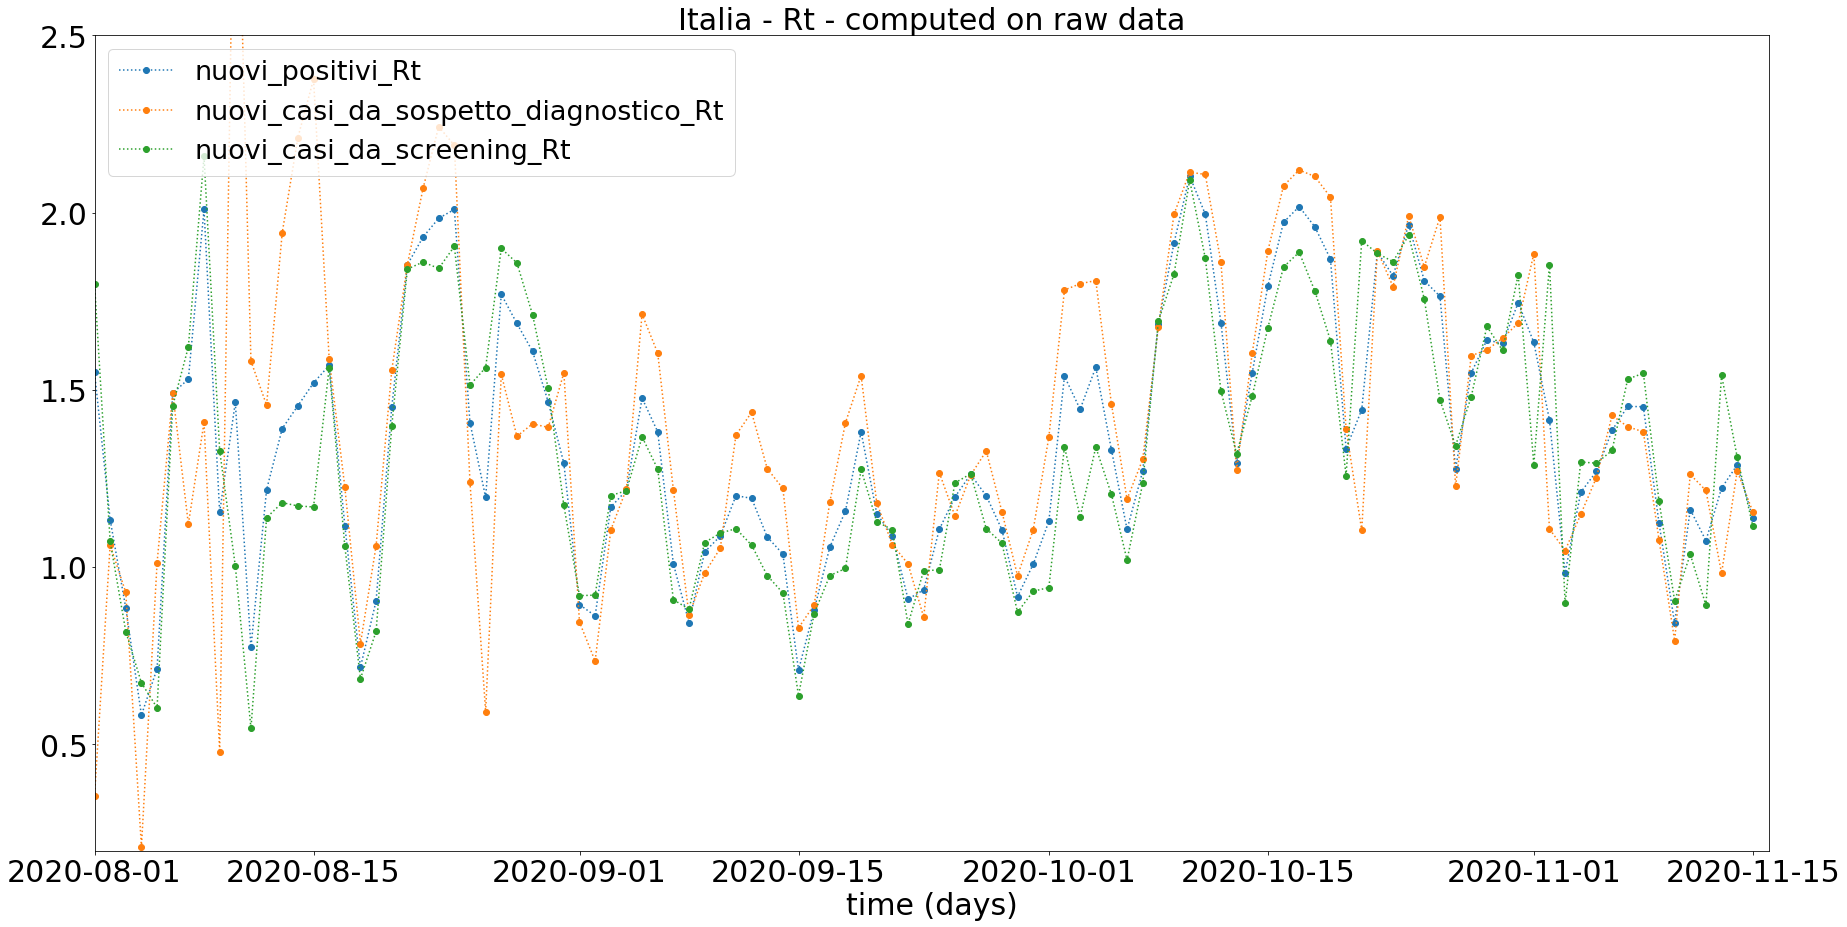

In [64]:
plot_series(
    'Italia - Rt - computed on raw data',    
    italy_raw_data, 
    [
        'nuovi_positivi_Rt',
        'nuovi_casi_da_sospetto_diagnostico_Rt',
        'nuovi_casi_da_screening_Rt'
    ],
    ylim=(0.2,2.5),
    xlim=(datetime(2020,8,1),datetime(2020,11,16))
)